In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
from tsnecuda import TSNE
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import ThreadPoolExecutor, as_completed

def load_single_embedding(args):
    emb_path, file = args
    return np.load(os.path.join(emb_path, file))

def load_embeddings(emb_path: str, file_list: list, meta_df: pd.DataFrame, num_workers: int=4):
    '''
    Load embeddings from a list of files in parallel.

    Args:
        emb_path (str): Path to the embeddings directory.
        file_list (list): List of files to load. Each file should be a .npy file.
        meta_df (pd.DataFrame): Metadata DataFrame. Columns should include 'file' and 'label'.
        num_workers (int): Number of workers to use for parallel processing.
    Returns:
        emb (np.array): Array of embeddings.
        labels (np.array): Array of labels.
    '''
    def load_file(file: str):
        file_path = os.path.join(emb_path, file)
        embedding = np.load(file_path)
        file_ = file.split('.')[0]
        label = meta_df.loc[meta_df['hash'] == file_, 'modification'].values[0]
        return embedding, label

    embeddings = []
    labels = []

    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = {executor.submit(load_file, file): file for file in file_list}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Loading embeddings"):
            emb, label = future.result()
            if emb is not None and label is not None:
                embeddings.append(emb)
                labels.append(label)

    return np.array(embeddings), np.array(labels)

def load_embeddings_v2(emb_path: str, file_list: list, meta_df: pd.DataFrame, query: str = None, num_workers: int = 4):
    '''
    Load embeddings from a list of files in parallel with optional filtering by query.

    Args:
        emb_path (str): Path to the embeddings directory.
        file_list (list): List of files to load. Each file should be a .npy file.
        meta_df (pd.DataFrame): Metadata DataFrame. Columns should include 'file' and 'label'.
        query (str, optional): Query string to filter metadata. Example: "modification='BASELINE'" or "snr>20".
        num_workers (int): Number of workers to use for parallel processing.
    Returns:
        emb (np.array): Array of embeddings.
        labels (np.array): Array of labels.
    '''
    # Filter metadata based on query condition if provided
    if query is not None:
        filtered_meta_df = meta_df.query(query)
        # Filter file_list to only include files from the filtered metadata
        filtered_hashes = set(filtered_meta_df['hash'].values)
        filtered_file_list = [file for file in file_list if file.split('.')[0] in filtered_hashes]
    else:
        filtered_file_list = file_list
        filtered_meta_df = meta_df
    
    print(f"Loading {len(filtered_file_list)} files after filtering.")
    
    def load_file(file: str):
        try:
            file_path = os.path.join(emb_path, file)
            embedding = np.load(file_path)
            file_hash = file.split('.')[0]
            label_row = filtered_meta_df.loc[filtered_meta_df['hash'] == file_hash]
            
            if label_row.empty:
                return None, None
                
            label = label_row['modification'].values[0]
            return embedding, label
        except Exception as e:
            print(f"Error loading {file}: {str(e)}")
            return None, None

    embeddings = []
    labels = []

    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = {executor.submit(load_file, file): file for file in filtered_file_list}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Loading embeddings"):
            emb, label = future.result()
            if emb is not None and label is not None:
                embeddings.append(emb)
                labels.append(label)

    return np.array(embeddings), np.array(labels)
# Perform t-SNE
def perform_tsne(embeddings):
    print(f"Original embedding shape: {embeddings.shape}")
    
    # Take the mean of each embedding if it's 3D
    if len(embeddings.shape) == 3:
        # Flatten the embeddings to 2D, keep the first dimension
        # For example, if the shape is (1000, 10, 256), it will be reshaped to (1000, 2560)
        embeddings = embeddings.reshape(embeddings.shape[0], -1)
        print(f"Reshaped embedding shape: {embeddings.shape}")
    
    # Standardize the features
    # scaler = StandardScaler()
    # embeddings_scaled = scaler.fit_transform(embeddings)
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_seed=42, device=2)
    tsne_results = tsne.fit_transform(embeddings)
    print(f"t-SNE results shape: {tsne_results.shape}")
    
    return tsne_results

# Plot t-SNE results
def plot_tsne(tsne_results, labels, title="t-SNE Visualization of Embeddings", figsize=(12, 8)):
    print(f"t-SNE results shape: {tsne_results.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Unique labels: {np.unique(labels)}")
    
    plt.figure(figsize=figsize)
    
    # Create scatter plot
    unique_labels = np.unique(labels)
    colors = sns.color_palette("husl", n_colors=len(unique_labels))
    
    for label, color in zip(unique_labels, colors):
        mask = labels == label
        plt.scatter(tsne_results[mask, 0], tsne_results[mask, 1], 
                   c=[color], label=label, alpha=0.6)
    
    plt.title(title)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    
    return plt


# MLAAD

In [3]:
mlaad_df = pd.read_csv('/nvme1/hungdx/Lightning-hydra/data/shortcutASV/mlaad/data.csv', sep='|')

In [6]:
mlaad_df

,hash,file_path,carrier,carrier_fine,modification,desc,target,partition
0,a137f05ed484104022d0995b1,wav/BASELINE/spoof/a137f05ed484104022d0995b1.wav,spoof,fake/en/MatchaTTS/northandsouth_48_f000053.wav,BASELINE,Baseline audio (unchanged).,spoof,test
1,a897c235715b2f3ac588c8457,wav/BASELINE/spoof/a897c235715b2f3ac588c8457.wav,spoof,fake/en/tts_models_en_ljspeech_fast_pitch/wive...,BASELINE,Baseline audio (unchanged).,spoof,train
2,7361cf82ca0c64dde59f052a7,wav/BASELINE/spoof/7361cf82ca0c64dde59f052a7.wav,spoof,fake/en/tts_models_en_ljspeech_tacotron2-DDC_p...,BASELINE,Baseline audio (unchanged).,spoof,test
3,f8b6649ba79f355476194c623,wav/BASELINE/spoof/f8b6649ba79f355476194c623.wav,spoof,fake/en/suno_bark/wives_and_daughters_17_f0000...,BASELINE,Baseline audio (unchanged).,spoof,train
4,78bb2a6691ef384d7a1670b00,wav/BASELINE/spoof/78bb2a6691ef384d7a1670b00.wav,spoof,fake/en/Mars5/hunters_space_01_f000024.wav,BASELINE,Baseline audio (unchanged).,spoof,test
...,...,...,...,...,...,...,...,...
7195,760ebd97c693a102f790c8f15,wav/REVERB/bona-fide/760ebd97c693a102f790c8f15...,bona-fide,original/en/poisoned_pen_01_f000076.wav,REVERB,"Reverb via np.convolve, with amount 1.00.",bona-fide,train
7196,8dbc6bdc73e9fa33dca29c66e,wav/REVERB/bona-fide/8dbc6bdc73e9fa33dca29c66e...,bona-fide,original/en/the_master_key_14_f000048.wav,REVERB,"Reverb via np.convolve, with amount 1.00.",bona-fide,test
7197,0f566ec2dd9185ebc96926ad1,wav/REVERB/bona-fide/0f566ec2dd9185ebc96926ad1...,bona-fide,original/en/jane_eyre_37_f000425.wav,REVERB,"Reverb via np.convolve, with amount 4.00.",bona-fide,train
7198,4e3c6f9b56621a97f096559b1,wav/REVERB/bona-fide/4e3c6f9b56621a97f096559b1...,bona-fide,original/en/pink_fairy_book_05_f000045.wav,REVERB,"Reverb via np.convolve, with amount 9.00.",bona-fide,test


In [4]:
# Load embeddings
#emb_path = "/nvme1/hungdx/Lightning-hydra/logs/eval/cnsl_noisy/emb/mlaad"
emb_path = "/nvme1/hungdx/Lightning-hydra/logs/eval/cnsl_noisy/emb/mlaad_echo_autotune_amp"

file_list = os.listdir(emb_path)

embeddings, labels = load_embeddings_v2(emb_path, file_list, mlaad_df, query="target=='bona-fide'")



Loading 3600 files after filtering.


Loading embeddings: 100%|██████████| 3600/3600 [00:06<00:00, 576.85it/s]


In [4]:
print("embedding shape: ", embeddings.shape)


embedding shape:  (3600, 144)


In [5]:
mlaad_df['modification'].unique()

array(['BASELINE', 'BIT_DEPTH', 'MP3_COMPRESSION', 'ADD_BACKGROUND_NOISE',
       'ADD_BACKGROUND_MUSIC', 'EQUALIZATION', 'FREQ_MINUS', 'FREQ_PLUS',
       'GAUSSIAN_NOISE', 'SILENCE_INJECTION', 'HIGH_PASS_FILTER',
       'LOW_PASS_FILTER', 'TIME_STRETCH', 'PITCH_SHIFT', 'ECHO',
       'AMPLITUDE_MODULATION', 'AUTOTUNE', 'REVERB'], dtype=object)

In [6]:
labels

array(['BASELINE', 'BASELINE', 'BASELINE', ..., 'REVERB', 'REVERB',
       'REVERB'], shape=(3600,), dtype='<U20')

Processing embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

Creating scatter plot: 100%|██████████| 18/18 [00:00<00:00, 718.94it/s]


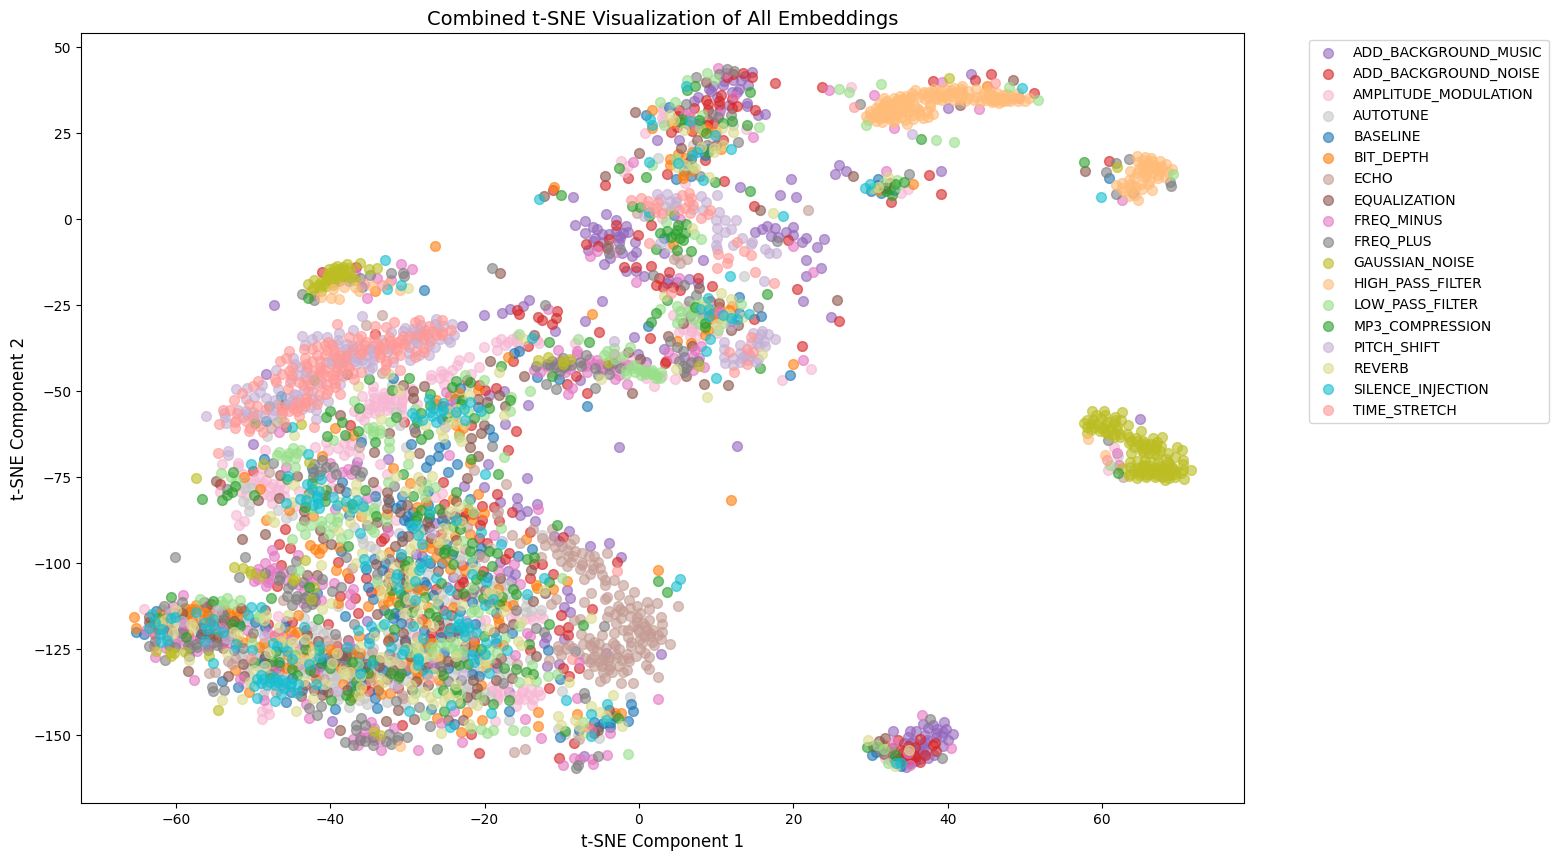

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tsnecuda import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tqdm import tqdm
np.random.seed(42)

def visualize_embeddings_single(embeddings_list, labels_list, names_list):
    """
    Visualize multiple embeddings using t-SNE in a single figure with modified labels.
    
    Args:
        embeddings_list: List of embedding arrays
        labels_list: List of corresponding labels
        names_list: List of names for each embedding
    """
    # Set up the figure
    plt.figure(figsize=(15, 10))
    
    # Color palette - different colors for each view and class
    colors = {
    'BASELINE': '#1f77b4',  # Blue
    'BIT_DEPTH': '#ff7f0e',  # Orange
    'MP3_COMPRESSION': '#2ca02c',  # Green
    'ADD_BACKGROUND_NOISE': '#d62728',  # Red
    'ADD_BACKGROUND_MUSIC': '#9467bd',  # Purple
    'EQUALIZATION': '#8c564b',  # Brown
    'FREQ_MINUS': '#e377c2',  # Pink
    'FREQ_PLUS': '#7f7f7f',  # Gray
    'GAUSSIAN_NOISE': '#bcbd22',  # Olive
    'SILENCE_INJECTION': '#17becf',  # Cyan
    'HIGH_PASS_FILTER': '#ffbb78',  # Light Orange
    'LOW_PASS_FILTER': '#98df8a',  # Light Green
    'TIME_STRETCH': '#ff9896',  # Light Red
    'PITCH_SHIFT': '#c5b0d5',  # Light Purple
    'ECHO': '#c49c94',  # Light Brown
    'AMPLITUDE_MODULATION': '#f7b6d2',  # Light Pink
    'AUTOTUNE': '#c7c7c7',  # Light Gray
    'REVERB': '#dbdb8d'  # Light Olive
    }

    
    # Initialize lists to store all t-SNE results
    all_tsne = []
    all_labels = []
    
    # Process each embedding
    for idx, (embeddings, labels, name) in enumerate(tqdm(zip(embeddings_list, labels_list, names_list) , total=len(embeddings_list), desc="Processing embeddings")):
        # Standardize the embeddings
        scaler = StandardScaler()
        embeddings_scaled = scaler.fit_transform(embeddings)
        
        # Apply t-SNE
        tsne = TSNE(
            n_components=2,
            random_seed=42,
  
        )
        embeddings_tsne = tsne.fit_transform(embeddings)
        
        # Store results with modified labels
        all_tsne.append(embeddings_tsne)
        modified_labels = np.array([f'{label}' for label in labels])
        all_labels.append(modified_labels)
    
    # Combine all results
    combined_tsne = np.vstack(all_tsne)
    combined_labels = np.concatenate(all_labels)
    
    #print(combined_labels)
    
    # Create scatter plot
    for label in tqdm(np.unique(combined_labels), desc="Creating scatter plot"):
        mask = combined_labels == label
        plt.scatter(
            combined_tsne[mask, 0],
            combined_tsne[mask, 1],
            c=[colors[label]],
            label=label,
            alpha=0.6,
            s=50
        )
    
    plt.title('Combined t-SNE Visualization of All Embeddings', fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.xlabel('t-SNE Component 1', fontsize=12)
    plt.ylabel('t-SNE Component 2', fontsize=12)
    
    return plt.gcf()

# Prepare the data
embeddings_list = [embeddings]
labels_list = [labels]
names_list = ['BASELINE', 'BIT_DEPTH', 'MP3_COMPRESSION', 'ADD_BACKGROUND_NOISE',
       'ADD_BACKGROUND_MUSIC', 'EQUALIZATION', 'FREQ_MINUS', 'FREQ_PLUS',
       'GAUSSIAN_NOISE', 'SILENCE_INJECTION', 'HIGH_PASS_FILTER',
       'LOW_PASS_FILTER', 'TIME_STRETCH', 'PITCH_SHIFT', 'ECHO',
       'AMPLITUDE_MODULATION', 'AUTOTUNE', 'REVERB']

# Create the visualization
fig = visualize_embeddings_single(embeddings_list, labels_list, names_list)

# Save the figure
plt.show()
#plt.savefig('embeddings_tsne_xlsr_conformertcm_clean_mlaad_bonafide.png', dpi=300, bbox_inches='tight')
# plt.close()

Processing embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/home/hung/miniconda3/envs/tsne/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
Creating scatter plot: 100%|██████████| 7/7 [00:00<00:00, 341.23it/s]


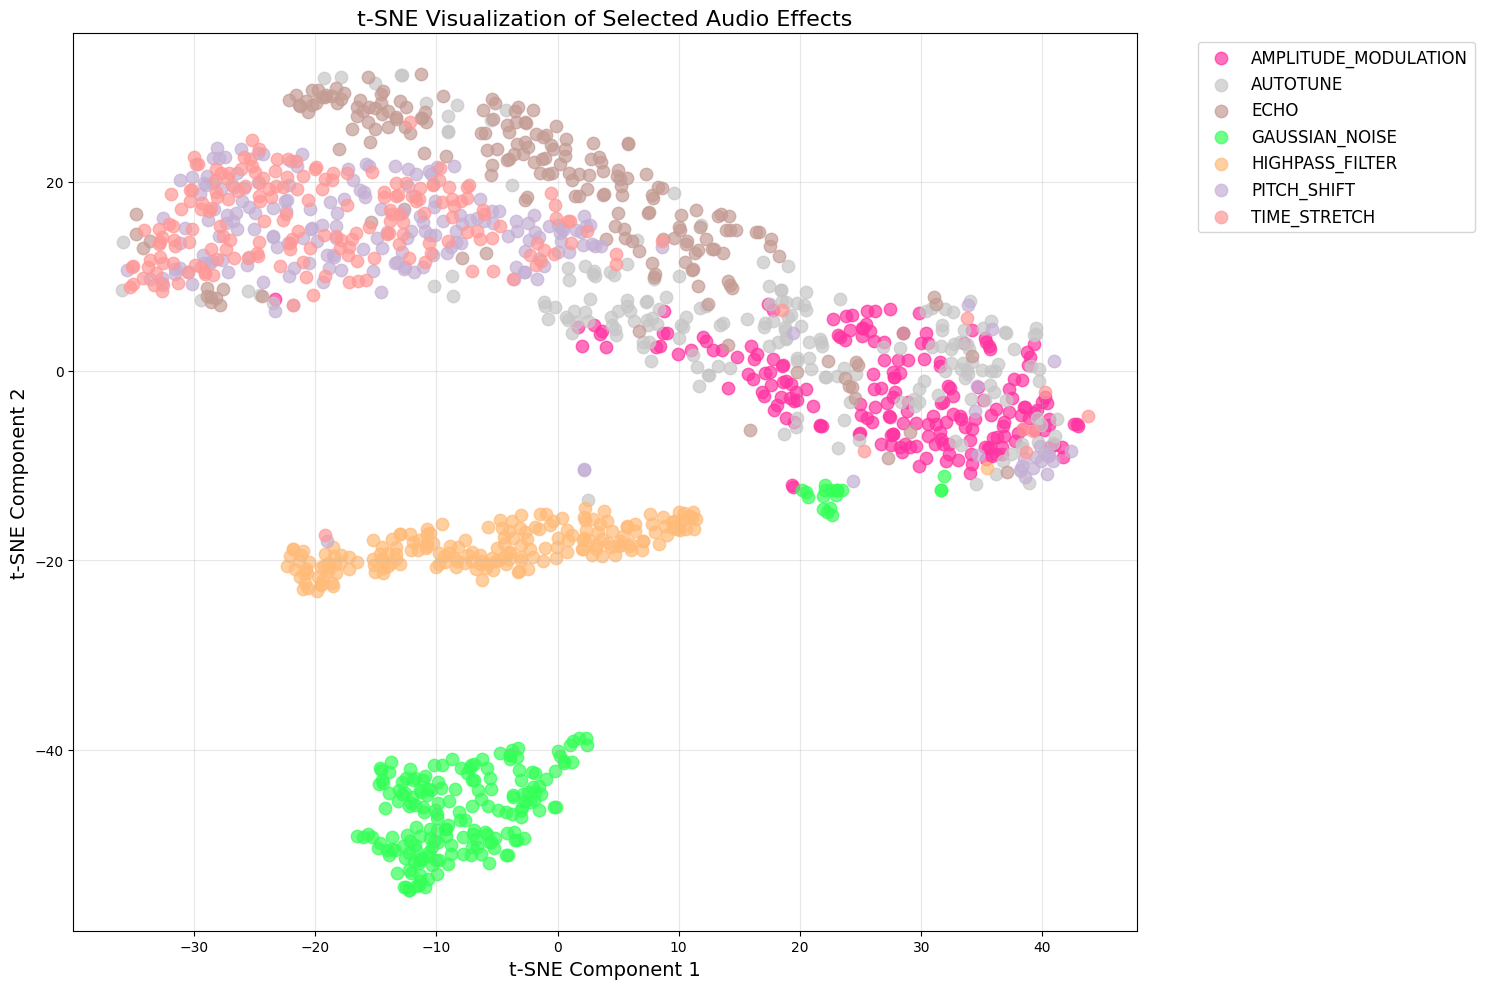

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE  # Using sklearn's TSNE instead of tsnecuda for better compatibility
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tqdm import tqdm
np.random.seed(42)

def visualize_filtered_embeddings(embeddings_list, labels_list, classes_to_show):
    """
    Visualize only specific classes from embeddings using t-SNE in a single figure.
    
    Args:
        embeddings_list: List of embedding arrays
        labels_list: List of corresponding labels
        classes_to_show: List of class names to visualize
    """
    # Set up the figure
    plt.figure(figsize=(15, 10))
    
    # Color palette for the selected classes
    colors = {
        'AUTOTUNE': '#c7c7c7',      # Light Gray
        'ECHO': '#c49c94',          # Light Brown
        'HIGHPASS_FILTER': '#ffbb78', # Light Orange
        'PITCH_SHIFT': '#c5b0d5',   # Light Purple
        'TIME_STRETCH': '#ff9896',   # Light Red
        "GAUSSIAN_NOISE": "#33FF57",
        "AMPLITUDE_MODULATION": "#FF33A1"
    }
    
    # Initialize lists to store filtered data
    all_filtered_tsne = []
    all_filtered_labels = []
    
    # Process each embedding
    for idx, (embeddings, labels, name) in enumerate(tqdm(zip(embeddings_list, labels_list, names_list), 
                                                         total=len(embeddings_list), 
                                                         desc="Processing embeddings")):
        # Filter data to include only the specified classes
        # Normalize class names for comparison (uppercase)
        upper_labels = [label.upper() for label in labels]
        upper_classes = [cls.upper() for cls in classes_to_show]
        
        # Create masks for each class (handling case variations)
        masks = []
        for cls in upper_classes:
            if cls == 'HIGHPASS_FILTER':
                # Check for both 'HIGHPASS_FILTER' and 'HIGH_PASS_FILTER'
                mask = np.array([(label == 'HIGHPASS_FILTER' or label == 'HIGH_PASS_FILTER') 
                                 for label in upper_labels])
            elif cls == 'AUTOTUNE':
                # Check for both 'AUTOTUNE' and 'AUTO_TUNE'
                mask = np.array([(label == 'AUTOTUNE' or label == 'AUTO_TUNE') 
                                 for label in upper_labels])
            else:
                mask = np.array([label == cls for label in upper_labels])
            masks.append(mask)
        
        # Combine all masks with OR operation
        combined_mask = np.zeros_like(upper_labels, dtype=bool)
        for mask in masks:
            combined_mask = combined_mask | mask
        
        # Apply the filter
        filtered_embeddings = embeddings[combined_mask]
        filtered_labels = np.array(labels)[combined_mask]
        
        # Skip if no embeddings match the filter
        if len(filtered_embeddings) == 0:
            continue
            
        # Standardize the filtered embeddings
        scaler = StandardScaler()
        embeddings_scaled = scaler.fit_transform(filtered_embeddings)
        
        # Apply t-SNE
        tsne = TSNE(
            n_components=2,
            random_state=42,
            perplexity=min(30, len(filtered_embeddings) - 1),  # Adjust perplexity based on sample size
            n_iter=1000,
            learning_rate='auto'
        )
        embeddings_tsne = tsne.fit_transform(embeddings_scaled)
        
        # Store results
        all_filtered_tsne.append(embeddings_tsne)
        all_filtered_labels.append(filtered_labels)
    
    # Combine all results
    if not all_filtered_tsne:
        raise ValueError("No matching classes found in the data")
        
    combined_tsne = np.vstack(all_filtered_tsne)
    combined_labels = np.concatenate(all_filtered_labels)
    
    import random

    random_colors = ["#FF5733", "#33FF57", "#3357FF", "#FF33A1", "#A133FF"]
    
    # Create scatter plot
    for label in tqdm(np.unique(combined_labels), desc="Creating scatter plot"):
        # Standardize label format for display
        display_label = label.upper()
        if display_label == "HIGH_PASS_FILTER":
            display_label = "HIGHPASS_FILTER"
        if display_label == "AUTO_TUNE":
            display_label = "AUTOTUNE"
            
        # Get the correct color key
        color_key = display_label
            
        mask = np.array([l.upper() == label.upper() for l in combined_labels])
        plt.scatter(
            combined_tsne[mask, 0],
            combined_tsne[mask, 1],
            c=[colors.get(color_key, random.choice(random_colors))],  # Use black as fallback
            label=display_label,
            alpha=0.7,
            s=80
        )
    
    plt.title('t-SNE Visualization of Selected Audio Effects', fontsize=16)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    plt.xlabel('t-SNE Component 1', fontsize=14)
    plt.ylabel('t-SNE Component 2', fontsize=14)
    plt.grid(alpha=0.3)
    
    return plt.gcf()

# Classes to visualize (we're handling potential naming variations in the function)
classes_to_show = ["AUTOTUNE", "ECHO", "HIGHPASS_FILTER", "PITCH_SHIFT", "TIME_STRETCH", "AMPLITUDE_MODULATION", "GAUSSIAN_NOISE"]

# Prepare the data
embeddings_list = [embeddings]  # Your embeddings variable
labels_list = [labels]  # Your labels variable
names_list = ['Audio Effects']  # Simplified name list

# Create the visualization
fig = visualize_filtered_embeddings(embeddings_list, labels_list, classes_to_show)

# Save the figure
plt.tight_layout()
plt.show()
# plt.savefig('filtered_embeddings_tsne_asv19_spoof.png', dpi=300, bbox_inches='tight')

# ASV19




In [6]:
asv19df = pd.read_csv('/nvme1/hungdx/Lightning-hydra/data/shortcutASV/asv19/data.csv', sep='|')


In [7]:
asv19df

,hash,file_path,carrier,carrier_fine,modification,desc,target,partition
0,a137f05ed484104022d0995b1,wav/BASELINE/spoof/a137f05ed484104022d0995b1.wav,spoof,ASVspoof2019_LA_eval/flac/LA_E_1060792.flac,BASELINE,Baseline audio (unchanged).,spoof,test
1,a897c235715b2f3ac588c8457,wav/BASELINE/spoof/a897c235715b2f3ac588c8457.wav,spoof,ASVspoof2019_LA_eval/flac/LA_E_2862018.flac,BASELINE,Baseline audio (unchanged).,spoof,train
2,7361cf82ca0c64dde59f052a7,wav/BASELINE/spoof/7361cf82ca0c64dde59f052a7.wav,spoof,ASVspoof2019_LA_eval/flac/LA_E_9756244.flac,BASELINE,Baseline audio (unchanged).,spoof,test
3,f8b6649ba79f355476194c623,wav/BASELINE/spoof/f8b6649ba79f355476194c623.wav,spoof,ASVspoof2019_LA_eval/flac/LA_E_1612753.flac,BASELINE,Baseline audio (unchanged).,spoof,train
4,78bb2a6691ef384d7a1670b00,wav/BASELINE/spoof/78bb2a6691ef384d7a1670b00.wav,spoof,ASVspoof2019_LA_eval/flac/LA_E_5475268.flac,BASELINE,Baseline audio (unchanged).,spoof,test
...,...,...,...,...,...,...,...,...
7195,8aacc36d45de8e1439e528f74,wav/REVERB/bona-fide/8aacc36d45de8e1439e528f74...,bona-fide,ASVspoof2019_LA_eval/flac/LA_E_4049611.flac,REVERB,"Reverb via np.convolve, with amount 10.00.",bona-fide,train
7196,5c49aa84abe162304e412ae78,wav/REVERB/bona-fide/5c49aa84abe162304e412ae78...,bona-fide,ASVspoof2019_LA_eval/flac/LA_E_2880944.flac,REVERB,"Reverb via np.convolve, with amount 8.00.",bona-fide,test
7197,6a1ccbbbd986ec0d6eab1528e,wav/REVERB/bona-fide/6a1ccbbbd986ec0d6eab1528e...,bona-fide,ASVspoof2019_LA_eval/flac/LA_E_9290615.flac,REVERB,"Reverb via np.convolve, with amount 9.00.",bona-fide,train
7198,4b9b1f1c8b84e9a598f163bd2,wav/REVERB/bona-fide/4b9b1f1c8b84e9a598f163bd2...,bona-fide,ASVspoof2019_LA_eval/flac/LA_E_8833209.flac,REVERB,"Reverb via np.convolve, with amount 4.00.",bona-fide,test


In [8]:
# Load embeddings
#emb_path = "/nvme1/hungdx/Lightning-hydra/logs/eval/cnsl_noisy/emb/asv19"
emb_path = "/nvme1/hungdx/Lightning-hydra/logs/eval/cnsl_noisy/emb/asv19_echo_autotune_amp"

file_list = os.listdir(emb_path)

embeddings, labels = load_embeddings_v2(emb_path, file_list, asv19df, query="carrier=='bona-fide'")


Loading 3600 files after filtering.


Loading embeddings: 100%|██████████| 3600/3600 [00:06<00:00, 580.13it/s]


Processing embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

Creating scatter plot: 100%|██████████| 18/18 [00:00<00:00, 444.48it/s]


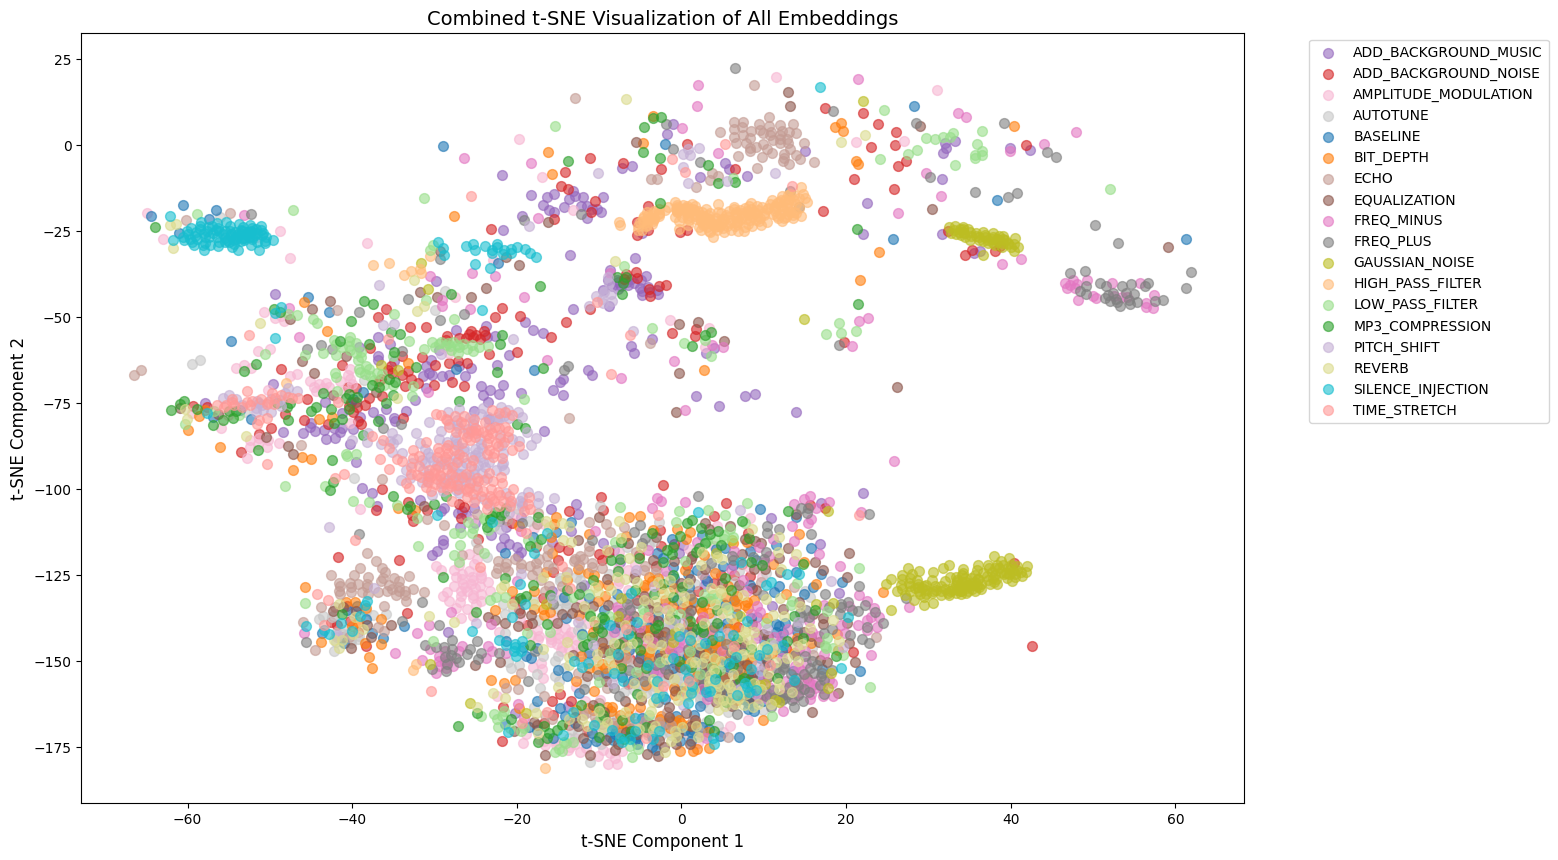

<Figure size 640x480 with 0 Axes>

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tsnecuda import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tqdm import tqdm
np.random.seed(42)

def visualize_embeddings_single(embeddings_list, labels_list, names_list):
    """
    Visualize multiple embeddings using t-SNE in a single figure with modified labels.
    
    Args:
        embeddings_list: List of embedding arrays
        labels_list: List of corresponding labels
        names_list: List of names for each embedding
    """
    # Set up the figure
    plt.figure(figsize=(15, 10))
    
    # Color palette - different colors for each view and class
    colors = {
    'BASELINE': '#1f77b4',  # Blue
    'BIT_DEPTH': '#ff7f0e',  # Orange
    'MP3_COMPRESSION': '#2ca02c',  # Green
    'ADD_BACKGROUND_NOISE': '#d62728',  # Red
    'ADD_BACKGROUND_MUSIC': '#9467bd',  # Purple
    'EQUALIZATION': '#8c564b',  # Brown
    'FREQ_MINUS': '#e377c2',  # Pink
    'FREQ_PLUS': '#7f7f7f',  # Gray
    'GAUSSIAN_NOISE': '#bcbd22',  # Olive
    'SILENCE_INJECTION': '#17becf',  # Cyan
    'HIGH_PASS_FILTER': '#ffbb78',  # Light Orange
    'LOW_PASS_FILTER': '#98df8a',  # Light Green
    'TIME_STRETCH': '#ff9896',  # Light Red
    'PITCH_SHIFT': '#c5b0d5',  # Light Purple
    'ECHO': '#c49c94',  # Light Brown
    'AMPLITUDE_MODULATION': '#f7b6d2',  # Light Pink
    'AUTOTUNE': '#c7c7c7',  # Light Gray
    'REVERB': '#dbdb8d'  # Light Olive
    }

    
    # Initialize lists to store all t-SNE results
    all_tsne = []
    all_labels = []
    
    # Process each embedding
    for idx, (embeddings, labels, name) in enumerate(tqdm(zip(embeddings_list, labels_list, names_list) , total=len(embeddings_list), desc="Processing embeddings")):
        # Standardize the embeddings
        scaler = StandardScaler()
        embeddings_scaled = scaler.fit_transform(embeddings)
        
        # Apply t-SNE
        tsne = TSNE(
            n_components=2,
            random_seed=42,
  
        )
        embeddings_tsne = tsne.fit_transform(embeddings)
        
        # Store results with modified labels
        all_tsne.append(embeddings_tsne)
        modified_labels = np.array([f'{label}' for label in labels])
        all_labels.append(modified_labels)
    
    # Combine all results
    combined_tsne = np.vstack(all_tsne)
    combined_labels = np.concatenate(all_labels)
    
    #print(combined_labels)
    
    # Create scatter plot
    for label in tqdm(np.unique(combined_labels), desc="Creating scatter plot"):
        mask = combined_labels == label
        plt.scatter(
            combined_tsne[mask, 0],
            combined_tsne[mask, 1],
            c=[colors[label]],
            label=label,
            alpha=0.6,
            s=50
        )
    
    plt.title('Combined t-SNE Visualization of All Embeddings', fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.xlabel('t-SNE Component 1', fontsize=12)
    plt.ylabel('t-SNE Component 2', fontsize=12)
    
    return plt.gcf()

# Prepare the data
embeddings_list = [embeddings]
labels_list = [labels]
names_list = ['BASELINE', 'BIT_DEPTH', 'MP3_COMPRESSION', 'ADD_BACKGROUND_NOISE',
       'ADD_BACKGROUND_MUSIC', 'EQUALIZATION', 'FREQ_MINUS', 'FREQ_PLUS',
       'GAUSSIAN_NOISE', 'SILENCE_INJECTION', 'HIGH_PASS_FILTER',
       'LOW_PASS_FILTER', 'TIME_STRETCH', 'PITCH_SHIFT', 'ECHO',
       'AMPLITUDE_MODULATION', 'AUTOTUNE', 'REVERB']

# Create the visualization
fig = visualize_embeddings_single(embeddings_list, labels_list, names_list)

# Save the figure
plt.show()
plt.savefig('embeddings_tsne_xlsr_conformertcm_clean_asv19_bonafide.png', dpi=300, bbox_inches='tight')
# plt.close()

Processing embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

/home/hung/miniconda3/envs/tsne/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
Creating scatter plot: 100%|██████████| 7/7 [00:00<00:00, 383.63it/s]


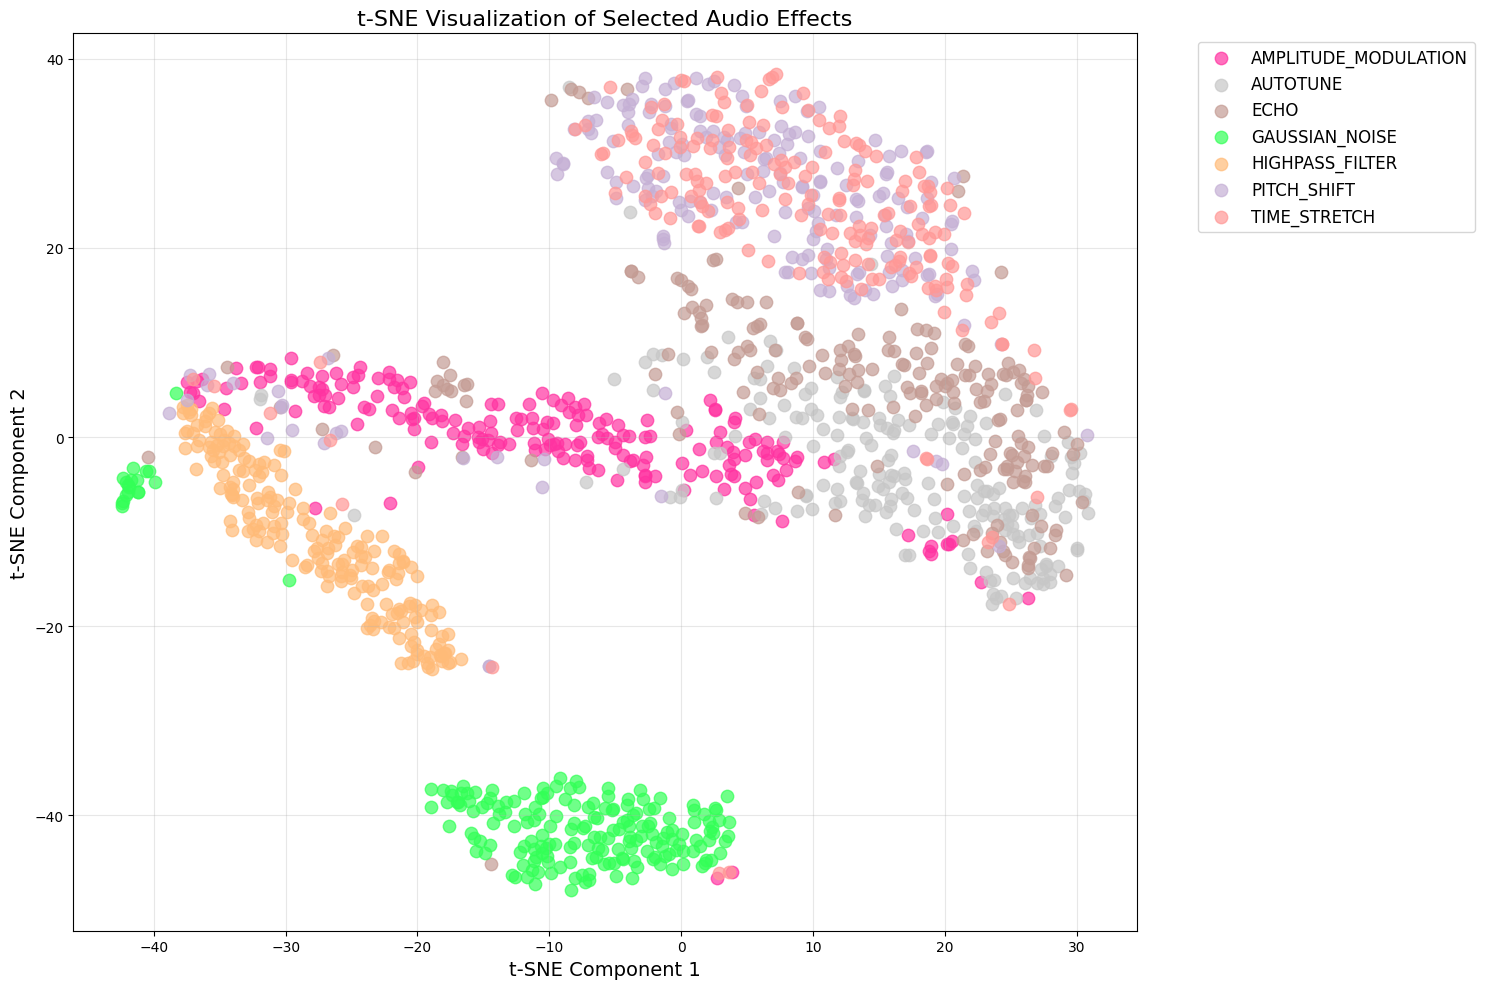

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE  # Using sklearn's TSNE instead of tsnecuda for better compatibility
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tqdm import tqdm
np.random.seed(42)

def visualize_filtered_embeddings(embeddings_list, labels_list, classes_to_show):
    """
    Visualize only specific classes from embeddings using t-SNE in a single figure.
    
    Args:
        embeddings_list: List of embedding arrays
        labels_list: List of corresponding labels
        classes_to_show: List of class names to visualize
    """
    # Set up the figure
    plt.figure(figsize=(15, 10))
    
    # Color palette for the selected classes
    colors = {
        'AUTOTUNE': '#c7c7c7',      # Light Gray
        'ECHO': '#c49c94',          # Light Brown
        'HIGHPASS_FILTER': '#ffbb78', # Light Orange
        'PITCH_SHIFT': '#c5b0d5',   # Light Purple
        'TIME_STRETCH': '#ff9896',   # Light Red
        "GAUSSIAN_NOISE": "#33FF57",
        "AMPLITUDE_MODULATION": "#FF33A1"
    }
    
    # Initialize lists to store filtered data
    all_filtered_tsne = []
    all_filtered_labels = []
    
    # Process each embedding
    for idx, (embeddings, labels, name) in enumerate(tqdm(zip(embeddings_list, labels_list, names_list), 
                                                         total=len(embeddings_list), 
                                                         desc="Processing embeddings")):
        # Filter data to include only the specified classes
        # Normalize class names for comparison (uppercase)
        upper_labels = [label.upper() for label in labels]
        upper_classes = [cls.upper() for cls in classes_to_show]
        
        # Create masks for each class (handling case variations)
        masks = []
        for cls in upper_classes:
            if cls == 'HIGHPASS_FILTER':
                # Check for both 'HIGHPASS_FILTER' and 'HIGH_PASS_FILTER'
                mask = np.array([(label == 'HIGHPASS_FILTER' or label == 'HIGH_PASS_FILTER') 
                                 for label in upper_labels])
            elif cls == 'AUTOTUNE':
                # Check for both 'AUTOTUNE' and 'AUTO_TUNE'
                mask = np.array([(label == 'AUTOTUNE' or label == 'AUTO_TUNE') 
                                 for label in upper_labels])
            else:
                mask = np.array([label == cls for label in upper_labels])
            masks.append(mask)
        
        # Combine all masks with OR operation
        combined_mask = np.zeros_like(upper_labels, dtype=bool)
        for mask in masks:
            combined_mask = combined_mask | mask
        
        # Apply the filter
        filtered_embeddings = embeddings[combined_mask]
        filtered_labels = np.array(labels)[combined_mask]
        
        # Skip if no embeddings match the filter
        if len(filtered_embeddings) == 0:
            continue
            
        # Standardize the filtered embeddings
        scaler = StandardScaler()
        embeddings_scaled = scaler.fit_transform(filtered_embeddings)
        
        # Apply t-SNE
        tsne = TSNE(
            n_components=2,
            random_state=42,
            perplexity=min(30, len(filtered_embeddings) - 1),  # Adjust perplexity based on sample size
            n_iter=1000,
            learning_rate='auto'
        )
        embeddings_tsne = tsne.fit_transform(embeddings_scaled)
        
        # Store results
        all_filtered_tsne.append(embeddings_tsne)
        all_filtered_labels.append(filtered_labels)
    
    # Combine all results
    if not all_filtered_tsne:
        raise ValueError("No matching classes found in the data")
        
    combined_tsne = np.vstack(all_filtered_tsne)
    combined_labels = np.concatenate(all_filtered_labels)
    
    import random

    random_colors = ["#FF5733", "#33FF57", "#3357FF", "#FF33A1", "#A133FF"]
    
    # Create scatter plot
    for label in tqdm(np.unique(combined_labels), desc="Creating scatter plot"):
        # Standardize label format for display
        display_label = label.upper()
        if display_label == "HIGH_PASS_FILTER":
            display_label = "HIGHPASS_FILTER"
        if display_label == "AUTO_TUNE":
            display_label = "AUTOTUNE"
            
        # Get the correct color key
        color_key = display_label
            
        mask = np.array([l.upper() == label.upper() for l in combined_labels])
        plt.scatter(
            combined_tsne[mask, 0],
            combined_tsne[mask, 1],
            c=[colors.get(color_key, random.choice(random_colors))],  # Use black as fallback
            label=display_label,
            alpha=0.7,
            s=80
        )
    
    plt.title('t-SNE Visualization of Selected Audio Effects', fontsize=16)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    plt.xlabel('t-SNE Component 1', fontsize=14)
    plt.ylabel('t-SNE Component 2', fontsize=14)
    plt.grid(alpha=0.3)
    
    return plt.gcf()

# Classes to visualize (we're handling potential naming variations in the function)
classes_to_show = ["AUTOTUNE", "ECHO", "HIGHPASS_FILTER", "PITCH_SHIFT", "TIME_STRETCH", "AMPLITUDE_MODULATION", "GAUSSIAN_NOISE"]

# Prepare the data
embeddings_list = [embeddings]  # Your embeddings variable
labels_list = [labels]  # Your labels variable
names_list = ['Audio Effects']  # Simplified name list

# Create the visualization
fig = visualize_filtered_embeddings(embeddings_list, labels_list, classes_to_show)

# Save the figure
plt.tight_layout()
plt.show()
# plt.savefig('filtered_embeddings_tsne_asv19_spoof.png', dpi=300, bbox_inches='tight')